## Access Animal Acoustic Tracking Delayed Qc (Parquet)

This Jupyter notebook demonstrates how to access and plot animal acoustic tracking delayed qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/541d4f15-122a-443d-ab4e-2b5feb08d6a0).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/animal_acoustic_tracking_delayed_qc.ipynb).


In [1]:
dataset_name = "animal_acoustic_tracking_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 69ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 1.36 s, sys: 243 ms, total: 1.61 s
Wall time: 12.2 s


In [5]:
aodn_dataset.dataset.partitioning.schema

transmitter_id: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
unique_partition_value = aodn_dataset.get_unique_partition_values('transmitter_id')
print(list(unique_partition_value)[0:2])  # showing a subset only

['A69-9001-1244', 'A69-9002-15948']


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


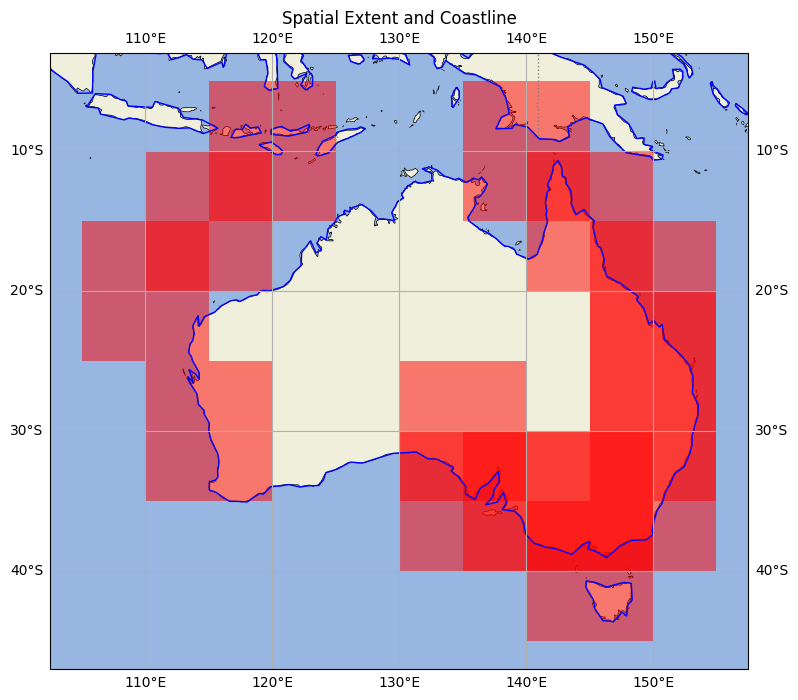

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2007-11-18 08:35:14'), Timestamp('2017-03-17 13:29:21'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:07:20,526 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/animal_acoustic_tracking_delayed_qc.parquet
2025-06-05 13:07:20,659 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'detection_timestamp': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': '',
  'units': 's',
  'comments': ''},
 'transmitter_id': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'installation_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'station_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'receiver_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'latitude': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'longitude': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'sensor_value': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'sensor_unit': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'unit

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%time
df = aodn_dataset.get_data(date_start='2009-06-01', date_end='2010-01-01', lat_min=-20, lat_max=-10, lon_min=140, lon_max=143, lat_varname='latitude', lon_varname='longitude')
df.info()

CPU times: user 10 µs, sys: 3 µs, total: 13 µs
Wall time: 17.4 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92687 entries, 0 to 92686
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   detection_timestamp       92687 non-null  datetime64[ns]
 1   installation_name         92687 non-null  object        
 2   station_name              92687 non-null  object        
 3   receiver_name             92687 non-null  object        
 4   latitude                  92687 non-null  float64       
 5   longitude                 92687 non-null  float64       
 6   sensor_value              10913 non-null  float64       
 7   sensor_unit               10913 non-null  object        
 8   FDA_QC                    92687 non-null  float32       
 9   Velocity_QC               92687 non-null  float32       
 10  Distance_QC               92687 non-null  float32       
 11  DetectionDistr

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

<Axes: xlabel='longitude', ylabel='latitude'>

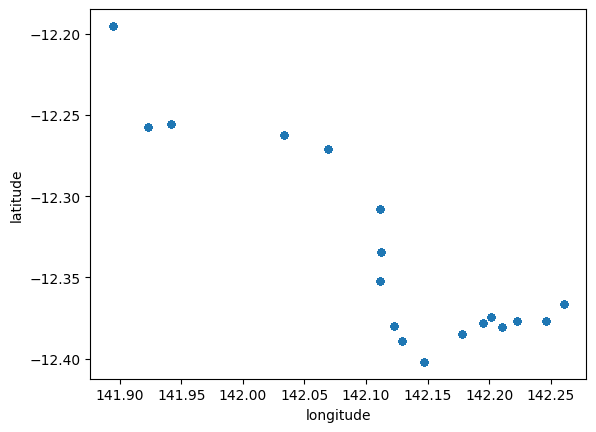

In [11]:
df[df['installation_name']== "Wenlock River"].plot.scatter(x='longitude', y='latitude')

## Create a TIME and scalar/number filter

In [12]:
%%time
df = aodn_dataset.get_data(date_start='2006-07-12', date_end='2023-02-05', scalar_filter = {'transmitter_id': 'A69-1105-106'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   detection_timestamp       36718 non-null  datetime64[ns]
 1   installation_name         36718 non-null  object        
 2   station_name              36718 non-null  object        
 3   receiver_name             36718 non-null  object        
 4   latitude                  36718 non-null  float64       
 5   longitude                 36718 non-null  float64       
 6   sensor_value              36718 non-null  float64       
 7   sensor_unit               36718 non-null  object        
 8   FDA_QC                    36718 non-null  float32       
 9   Velocity_QC               36718 non-null  float32       
 10  Distance_QC               36718 non-null  float32       
 11  DetectionDistribution_QC  36718 non-null  float32       
 12  DistanceRelease_QC

<Axes: xlabel='longitude', ylabel='latitude'>

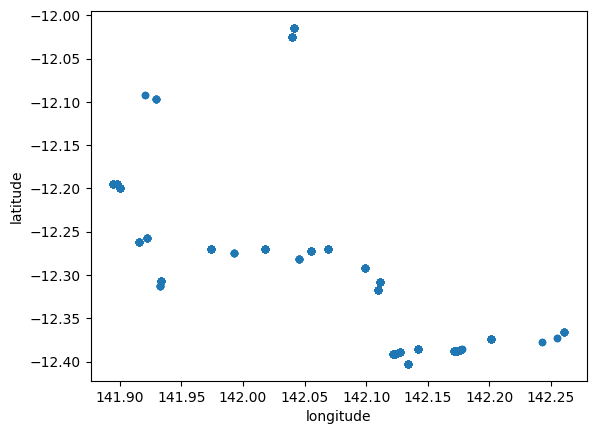

In [13]:
df[df['installation_name']== "Wenlock River"].plot.scatter(x='longitude', y='latitude')

In [14]:
aodn_dataset.get_data(date_start='2006-07-12', date_end='2023-02-05', scalar_filter = {'transmitter_id': 'A69-1105-1'})

,detection_timestamp,installation_name,station_name,receiver_name,latitude,longitude,sensor_value,sensor_unit,FDA_QC,Velocity_QC,Distance_QC,DetectionDistribution_QC,DistanceRelease_QC,ReleaseDate_QC,ReleaseLocation_QC,Detection_QC,filename,transmitter_id,timestamp,polygon
0,2013-10-04 15:31:41,Bondi Line,BL 3,VR2W-111253,-33.902730,151.302950,142.0,ADC,2.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1380585600,0103000000010000000500000000000000002062400000...
1,2013-10-30 11:37:40,Bondi Line,BL 3,VR2W-111253,-33.902730,151.302950,160.0,ADC,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1380585600,0103000000010000000500000000000000002062400000...
2,2013-10-30 11:50:03,Bondi Line,BL 2,VR2W-114536,-33.898540,151.295900,160.0,ADC,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1380585600,0103000000010000000500000000000000002062400000...
3,2014-07-05 00:31:07,Narooma Line,N7,VR2W-122586,-36.257780,150.209488,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1404172800,0103000000010000000500000000000000002062400000...
4,2014-07-25 22:15:50,Narooma Line,N6,VR2W-122588,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1404172800,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2016-12-15 23:27:49,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
82,2016-12-15 23:29:28,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
83,2016-12-15 23:31:23,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
84,2016-12-15 23:33:40,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...


In [15]:
aodn_dataset.get_data(scalar_filter = {'transmitter_id': 'A69-1105-1'})

,detection_timestamp,installation_name,station_name,receiver_name,latitude,longitude,sensor_value,sensor_unit,FDA_QC,Velocity_QC,Distance_QC,DetectionDistribution_QC,DistanceRelease_QC,ReleaseDate_QC,ReleaseLocation_QC,Detection_QC,filename,transmitter_id,timestamp,polygon
0,2013-10-04 15:31:41,Bondi Line,BL 3,VR2W-111253,-33.902730,151.302950,142.0,ADC,2.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1380585600,0103000000010000000500000000000000002062400000...
1,2013-10-30 11:37:40,Bondi Line,BL 3,VR2W-111253,-33.902730,151.302950,160.0,ADC,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1380585600,0103000000010000000500000000000000002062400000...
2,2013-10-30 11:50:03,Bondi Line,BL 2,VR2W-114536,-33.898540,151.295900,160.0,ADC,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1380585600,0103000000010000000500000000000000002062400000...
3,2014-07-05 00:31:07,Narooma Line,N7,VR2W-122586,-36.257780,150.209488,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1404172800,0103000000010000000500000000000000002062400000...
4,2014-07-25 22:15:50,Narooma Line,N6,VR2W-122588,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1404172800,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,2016-12-15 23:27:49,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
82,2016-12-15 23:29:28,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
83,2016-12-15 23:31:23,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
84,2016-12-15 23:33:40,Narooma Line,N6,VR2AR-545636,-36.258719,150.200573,16.0,ADC,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,A69-1105-1_110520781_117548977.csv,A69-1105-1,1480550400,0103000000010000000500000000000000002062400000...
